# Optimal Transport Project

*Authors : Romain Avouac, Slimane Thabet*

In [0]:
from time import time
from multiprocessing import cpu_count

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from torchvision import datasets, transforms

In [0]:
# GPU configuration
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

## Load an preprocess MNIST data

In [0]:
# Get MNIST pictures as Torch dataloader
batch_size = 128

mnist = datasets.MNIST('data', train=True, download=True).data.float() / 255
# Perform transformation directly on raw data rather than in the DataLoader
# => avoids overhead of transforming at each batch call => much faster epochs.
mnist = transforms.Normalize((0.5,), (0.5,))(mnist) # Normalize in [-1,1]
mnist = mnist.unsqueeze(-1) # Add channel dimension
mnist_dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, 
                                               shuffle=True)

In [0]:
img_shape = mnist_dataloader.dataset[0].shape
n_pixels = img_shape[0] * img_shape[1] * img_shape[2]

## Vanilla GAN

In [0]:
class GANGenerator(nn.Module):
    def __init__(self, input_size, d1, output_shape):
        super(GANGenerator, self).__init__()

        self.map1 = nn.Linear(input_size, d1)
        self.map2 = nn.Linear(self.map1.out_features, d1*2)
        self.map3 = nn.Linear(self.map2.out_features, d1*4)
        self.map4 = nn.Linear(self.map3.out_features, 
                              output_shape[0] * output_shape[1] * output_shape[2])

        self.act = nn.LeakyReLU(negative_slope=0.2)
        self.act_out = nn.Tanh()
        self.output_shape = output_shape

    def forward(self, x):
        x = self.act(self.map1(x))
        x = self.act(self.map2(x))
        x = self.act(self.map3(x))
        x = self.act_out(self.map4(x))
        
        return torch.reshape(x, (-1,)+self.output_shape)

In [0]:
class GANCritic(nn.Module):
    def __init__(self, input_size, d1):
        super(GANCritic, self).__init__()

        self.map1 = nn.Linear(input_size, d1)
        self.map2 = nn.Linear(self.map1.out_features, d1//2)
        self.map3 = nn.Linear(self.map2.out_features, d1//4)
        self.map4 = nn.Linear(self.map3.out_features, 1)

        self.act = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.act(self.map1(x))
        x = F.dropout(x, 0.3)
        x = self.act(self.map2(x))
        x = F.dropout(x, 0.3)
        x = self.act(self.map3(x))
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.map4(x))

        return x

In [0]:
class GAN():
    
    def __init__(self, dataloader, generator, critic, lr=0.0001):

        self.dataloader = dataloader

        # default parameters for mnist 
        self.img_rows = dataloader.dataset[0].shape[0]
        self.img_cols = dataloader.dataset[0].shape[1]
        self.img_channels = dataloader.dataset[0].shape[2]
        self.img_shape = (self.img_channels, self.img_rows, self.img_cols)
        self.z_dim = z_dim
        self.lr = lr

        self.generator = generator.to(device)
        self.critic = critic.to(device)

        
    def sample_data(self, n_sample):
        z_random = np.random.randn(n_sample, self.z_dim)
        z_random = torch.FloatTensor(z_random).to(device)
        samples = self.generator(z_random)
        samples = samples.detach().cpu().numpy()
        return samples
        
    def train(self, epochs=100, print_interval=10, save_generator_path=None):
        
        criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
        d_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr)
        g_optimizer = optim.Adam(self.generator.parameters(), lr=self.lr)
        d_steps = 1
        g_steps = 1

        t = time()
        
        for epoch in range(epochs):
            
            for batch in self.dataloader:
                batch = batch.type(torch.FloatTensor).to(device)

                for d_index in range(d_steps):
                    # 1. Train D on real+fake
                    self.critic.zero_grad()

                    #  1A: Train D on real
                    d_real_data = Variable(batch.to(device))
                    d_real_decision = self.critic(d_real_data)
                    y_real = Variable(torch.ones(d_real_decision.shape).to(device))
                    d_real_error = criterion(d_real_decision, y_real)
        
                    #  1B: Train D on fake
                    d_gen_input = torch.randn((batch.shape[0], self.z_dim))
                    d_gen_input = Variable(d_gen_input.to(device))
                    d_fake_data = self.generator(d_gen_input).detach()  # detach to avoid training G on these labels
                    d_fake_decision = self.critic(d_fake_data)
                    y_fake = Variable(torch.zeros(d_real_decision.shape).to(device))
                    d_fake_error = criterion(d_fake_decision, y_fake) 

                    # Backward propagation on the sum of the two losses
                    d_train_loss = d_real_error + d_fake_error
                    d_train_loss.backward()
                    d_optimizer.step() # Only optimizes D's parameters
        
                for g_index in range(g_steps):
                    # 2. Train G on D's response (but DO NOT train D on these labels)
                    self.generator.zero_grad()
        
                    gen_input = torch.randn((batch.shape[0], self.z_dim))
                    gen_input = Variable(gen_input.to(device))
                    g_fake_data = self.generator(gen_input)
                    dg_fake_decision = self.critic(g_fake_data)
                    y_ones = Variable(torch.ones(dg_fake_decision.shape).to(device))
                    g_error = criterion(dg_fake_decision, y_ones)   # Train G to pretend it's genuine
        
                    g_error.backward()
                    g_optimizer.step()  # Only optimizes G's parameters
                    
    
            if epoch > 0 and epoch % print_interval == 0:
                de = d_train_loss.detach().cpu().numpy()
                ge = g_error.detach().cpu().numpy()
                print("Epoch %s: C_loss =  %s ;  G_loss = %s;  time (%s)" %
                      (epoch, de, ge, time()-t))
                
            # if epoch % (print_interval*5) == 0:
            #     samples = self.sample_data(3)*0.5 + 0.5
            #     for img in samples:
            #         plt.figure()
            #         plt.imshow(img[0,:,:], cmap='gray')
            #         plt.show()

        if save_generator_path is not None:
            torch.save(self.generator.state_dict(), save_generator_path)


In [0]:
# Vanilla GAN parameters
z_dim = 32
G_dim_init = 128
C_dim_init = 1024
lr = 0.0002
n_epochs = 100

save_generator_path = 'vanilla_gan_gen.pt'

In [9]:
TRAIN_MODE = True

if TRAIN_MODE:
    # Train GAN and save generator weights
    gan_generator = GANGenerator(z_dim, G_dim_init, img_shape)
    gan_critic = GANCritic(n_pixels, C_dim_init)
    gan = GAN(mnist_dataloader, gan_generator, gan_critic, lr=lr)
    gan.train(n_epochs, save_generator_path=save_generator_path) # Change path to None to prevent saving weights
else:
    # Load previously trained generator weights
    gan_generator = GANGenerator(z_dim, G_dim_init, img_shape)
    gan_generator.load_state_dict(torch.load(save_generator_path))
    gan_critic = GANCritic(n_pixels, C_dim_init) # Not used
    gan = GAN(mnist_dataloader, gan_generator, gan_critic, lr=lr)

Epoch 0: C_loss =  0.20023069 ;  G_loss = 3.284827;  time (3.3559372425079346)
Epoch 10: C_loss =  0.28647757 ;  G_loss = 3.4791267;  time (36.521650075912476)
Epoch 20: C_loss =  0.5631751 ;  G_loss = 2.551751;  time (69.55935096740723)
Epoch 30: C_loss =  0.9133538 ;  G_loss = 1.4733357;  time (102.20993828773499)
Epoch 40: C_loss =  0.88182735 ;  G_loss = 1.2787387;  time (134.6884036064148)
Epoch 50: C_loss =  0.7197009 ;  G_loss = 1.798212;  time (167.18406105041504)
Epoch 60: C_loss =  0.81306267 ;  G_loss = 1.785352;  time (199.16952919960022)
Epoch 70: C_loss =  1.0542004 ;  G_loss = 1.3857416;  time (231.22869229316711)
Epoch 80: C_loss =  1.0735631 ;  G_loss = 1.2467358;  time (263.0366938114166)
Epoch 90: C_loss =  1.1333432 ;  G_loss = 1.0951467;  time (294.580472946167)


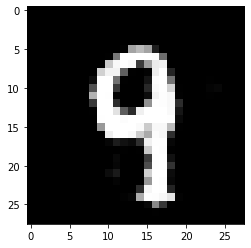

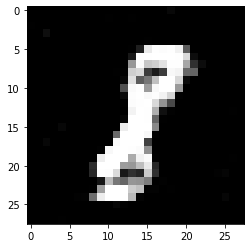

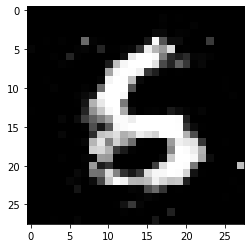

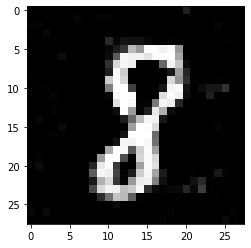

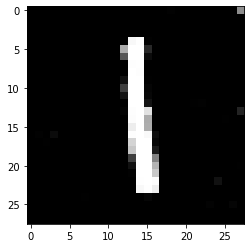

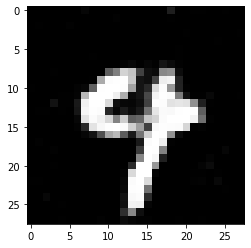

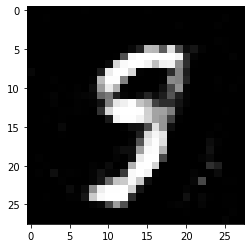

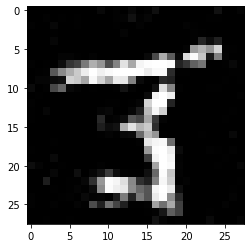

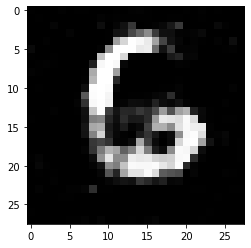

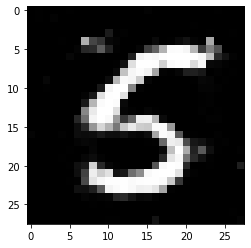

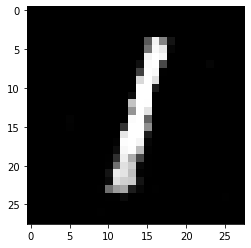

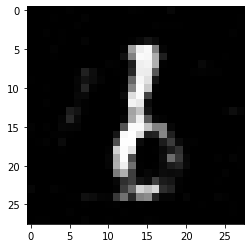

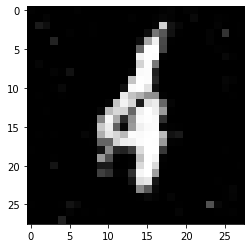

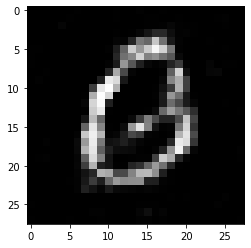

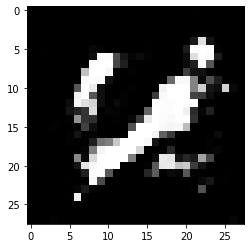

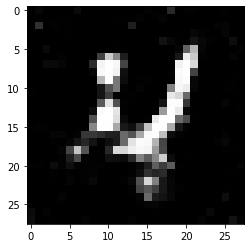

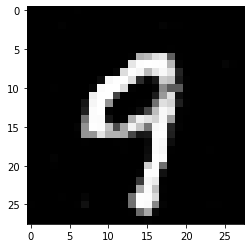

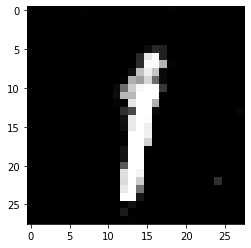

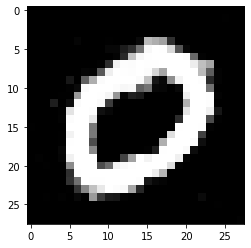

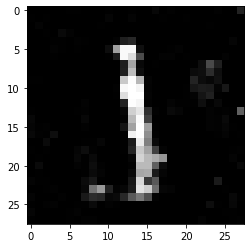

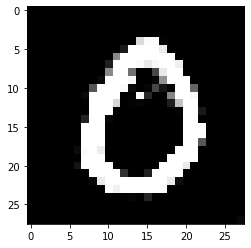

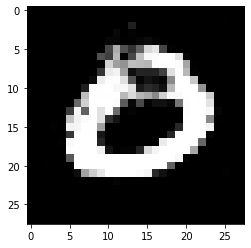

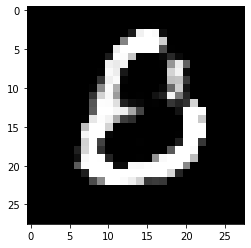

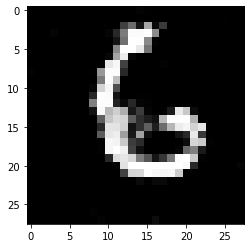

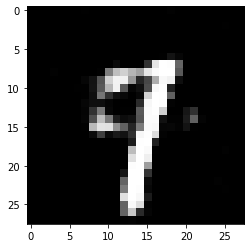

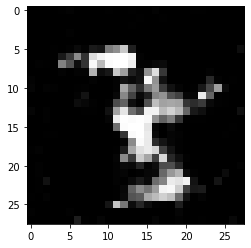

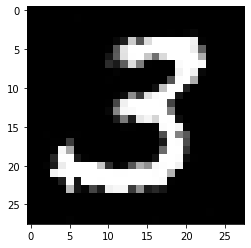

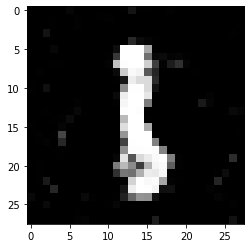

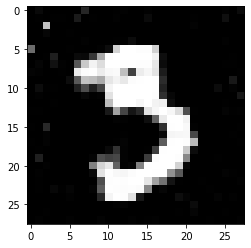

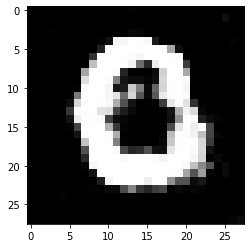

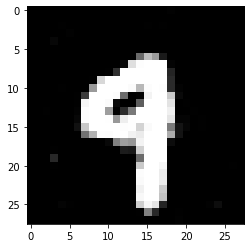

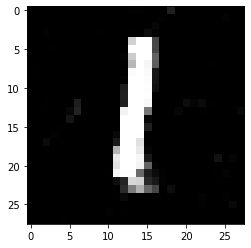

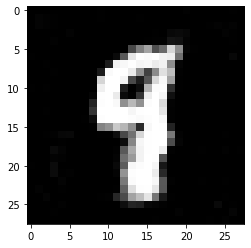

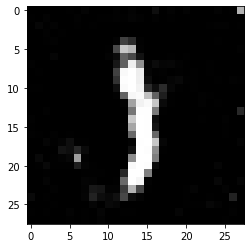

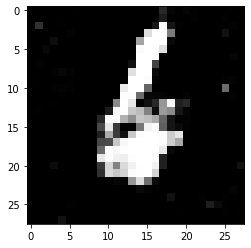

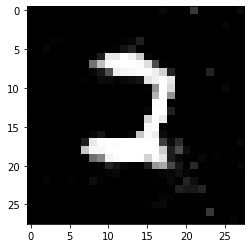

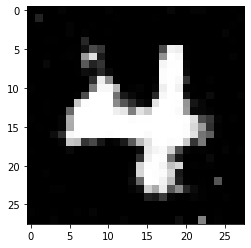

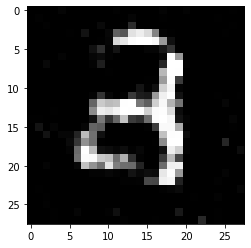

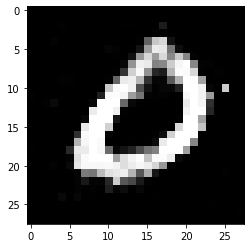

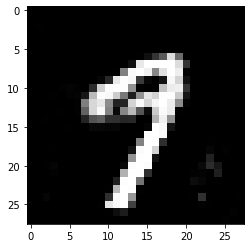

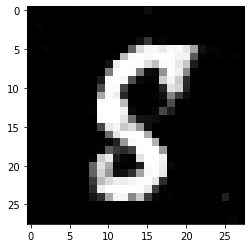

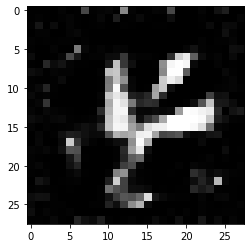

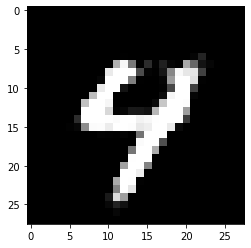

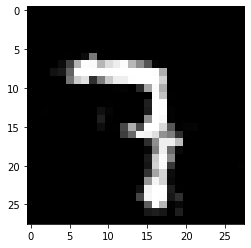

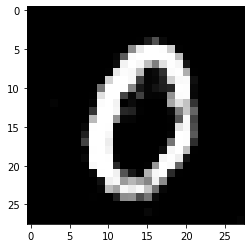

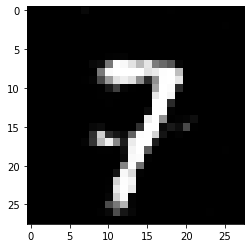

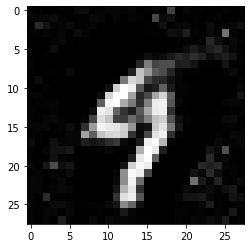

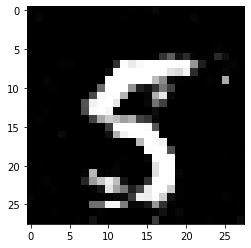

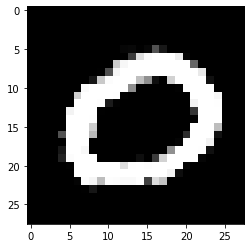

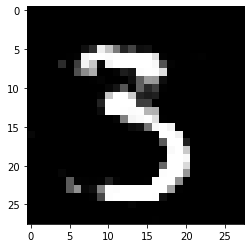

In [12]:
# Plot some generated images
samples = gan.sample_data(50)*0.5 + 0.5
for img in samples:
    plt.figure()
    plt.imshow(img[:,:,0], cmap='gray')
    plt.show()

## DC-GAN